<a href="https://colab.research.google.com/github/roesta07/Business-Analysis-Template/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Imports and utility functions
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install pymc3==3.8
    !pip install --upgrade daft
    !pip install --upgrade theano
    !pip install causalgraphicalmodels
    !pip install watermark
    !pip install arviz --no-dependencies
    !pip install netCDF4
    !pip install xarray

     |████████████████████████████████| 911kB 5.8MB/s 
     |████████████████████████████████| 1.5MB 46.0MB/s 
     |████████████████████████████████| 727kB 39.7MB/s 
     |████████████████████████████████| 4.3MB 46.0MB/s 
     |████████████████████████████████| 296kB 47.5MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
  Created wheel for daft: filename=daft-0.1.0-cp36-none-any.whl size=11375 sha256=153c1b695b2afebd7ea9984853fe376f96e447ba63ba78b2d925d043aa31d3d4
  Stored in directory: /root/.cache/pip/wheels/37/e9/8a/4186b68a6a3a042e0947b445ec6184e61b583bfad59af6fe49
Successfully built daft
  Found existing installation: daft 0.0.4
    Uninstalling daft-0.0.4:
      Successfully uninstalled daft-0.0.4
Requirement already up-to-date: theano in /usr/local/lib/python3.6/dist-packages (1.0.5)


In [5]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import daft
from theano import theano

from scipy.interpolate import griddata
from causalgraphicalmodels import CausalGraphicalModel

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
# %load_ext watermark
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

In [80]:
np.random.seed(2)
## simulating for 10 years
N=10*12

profit=np.zeros(N)
## for seven years marketing predicted profit
y_7=7*12
M_exp=np.zeros(N)
RD_exp=np.zeros(N)
M_exp[:y_7]=stats.halfnorm(0.35,0.2).rvs(y_7)
RD_exp[:y_7]=stats.halfnorm(0.25,0.5).rvs(y_7)
profit[:y_7]=stats.norm(M_exp[:y_7]*10,2).rvs(y_7)
RD_exp[y_7:]=stats.halfnorm(0.25,0.5).rvs(size=(N-y_7))
M_exp[y_7:]=stats.halfnorm(RD_exp[y_7:]+0.10,0.5).rvs(N-y_7)
profit[y_7:]=stats.norm(RD_exp[y_7:]*10,3).rvs((N-y_7))
## y as year 0-10
y=np.arange(0,10)
# each year has 12months
m=np.array(list(np.arange(1,13))*10)

len(m)

120

In [81]:
df=pd.DataFrame({
    'year':np.repeat(y,N/len(y),axis=0),
    'month':m,
    'RD_exp':RD_exp,
    'M_exp':M_exp,
    'profit': profit,
})
df.head(20)

,year,month,RD_exp,M_exp,profit
0,0,1,0.451946,0.433352,12.550901
1,0,2,0.942259,0.361253,5.254775
2,0,3,0.933618,0.777239,10.835913
3,0,4,0.858943,0.678054,2.808850
4,0,5,0.481003,0.708687,7.816978
5,0,6,0.425444,0.518349,6.731659
6,0,7,0.440933,0.450576,3.776805
7,0,8,0.533138,0.599058,4.238617
8,0,9,0.352104,0.561590,6.408945
9,0,10,0.953348,0.531802,4.688780


In [109]:
## it will be easy to work with standarize data

def standarize(col):
  return (col-col.mean())/col.std()




/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:64: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  self.fig.tight_layout(*args, **kwargs)


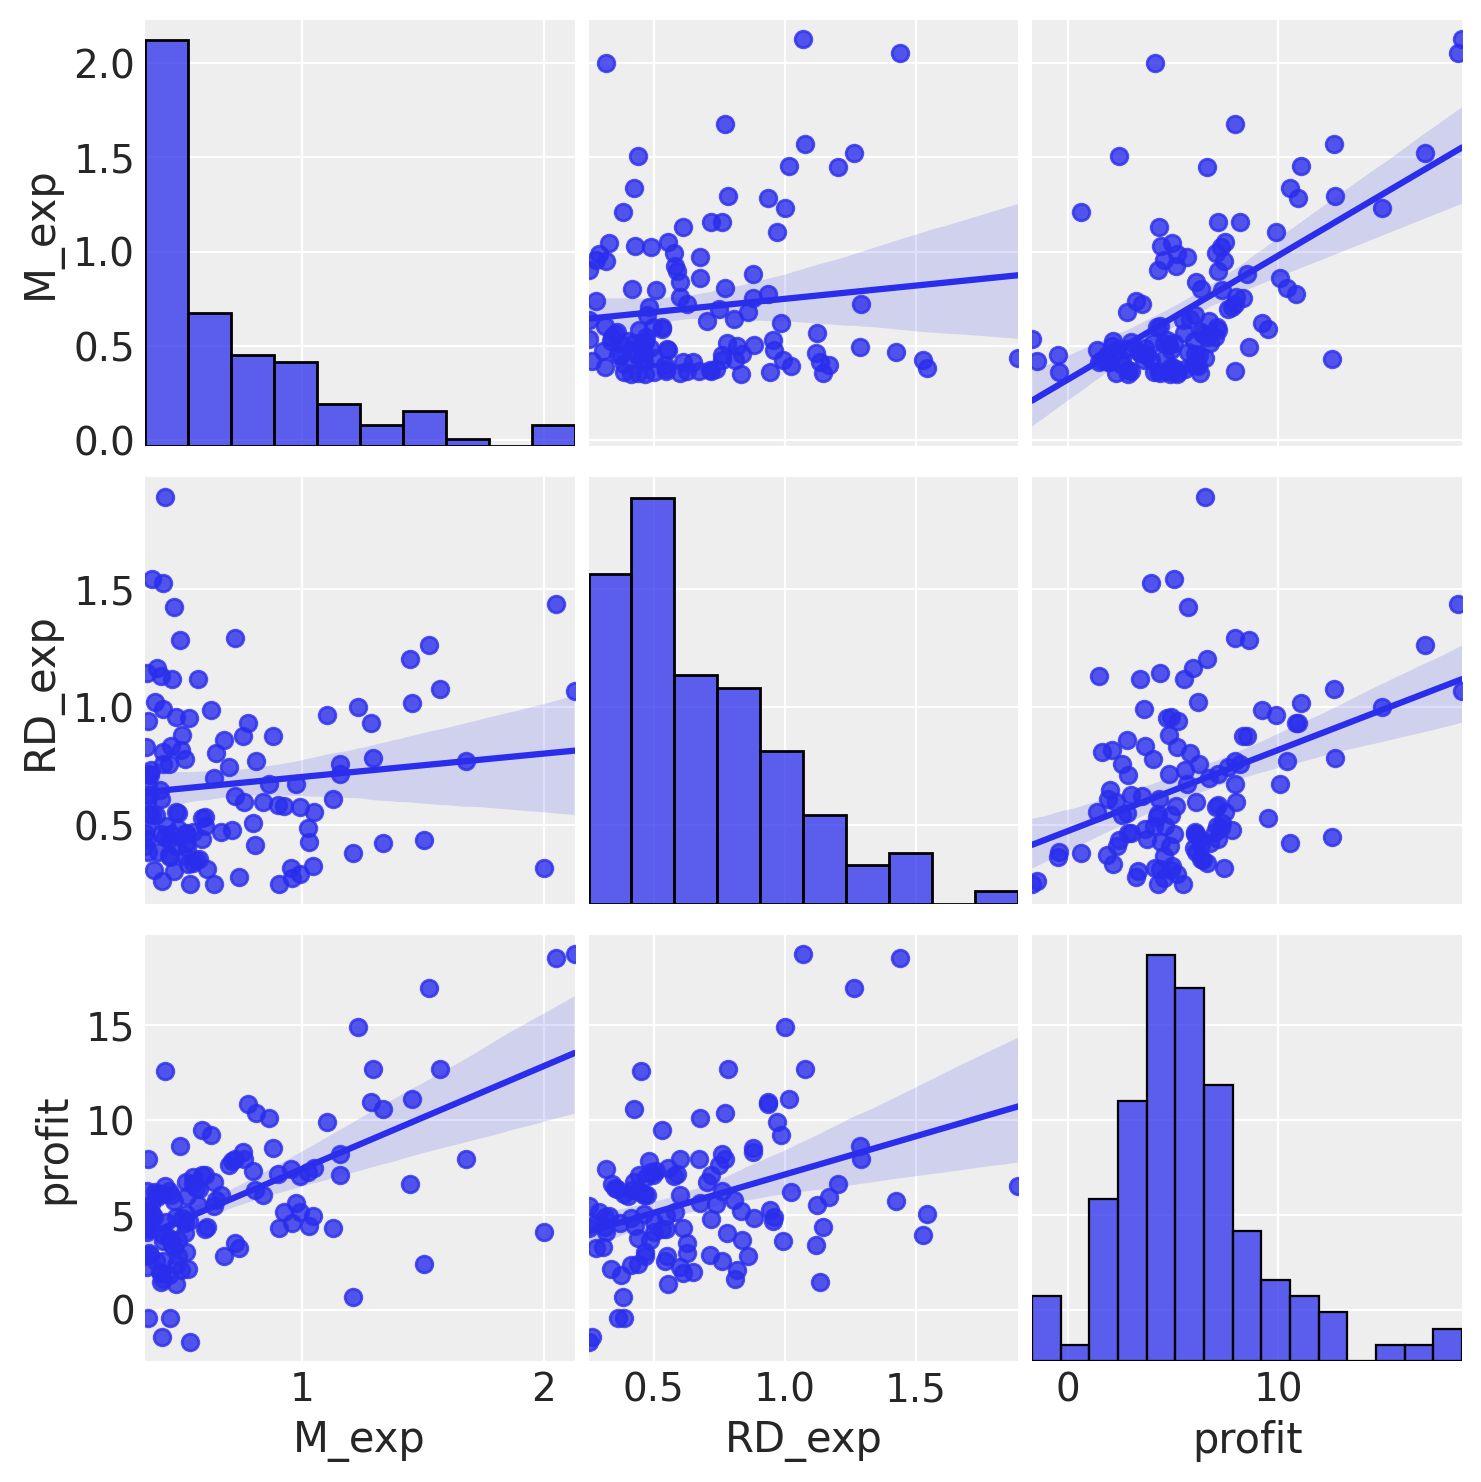

In [89]:
sns.pairplot(df[['M_exp','RD_exp','profit']],kind='reg')

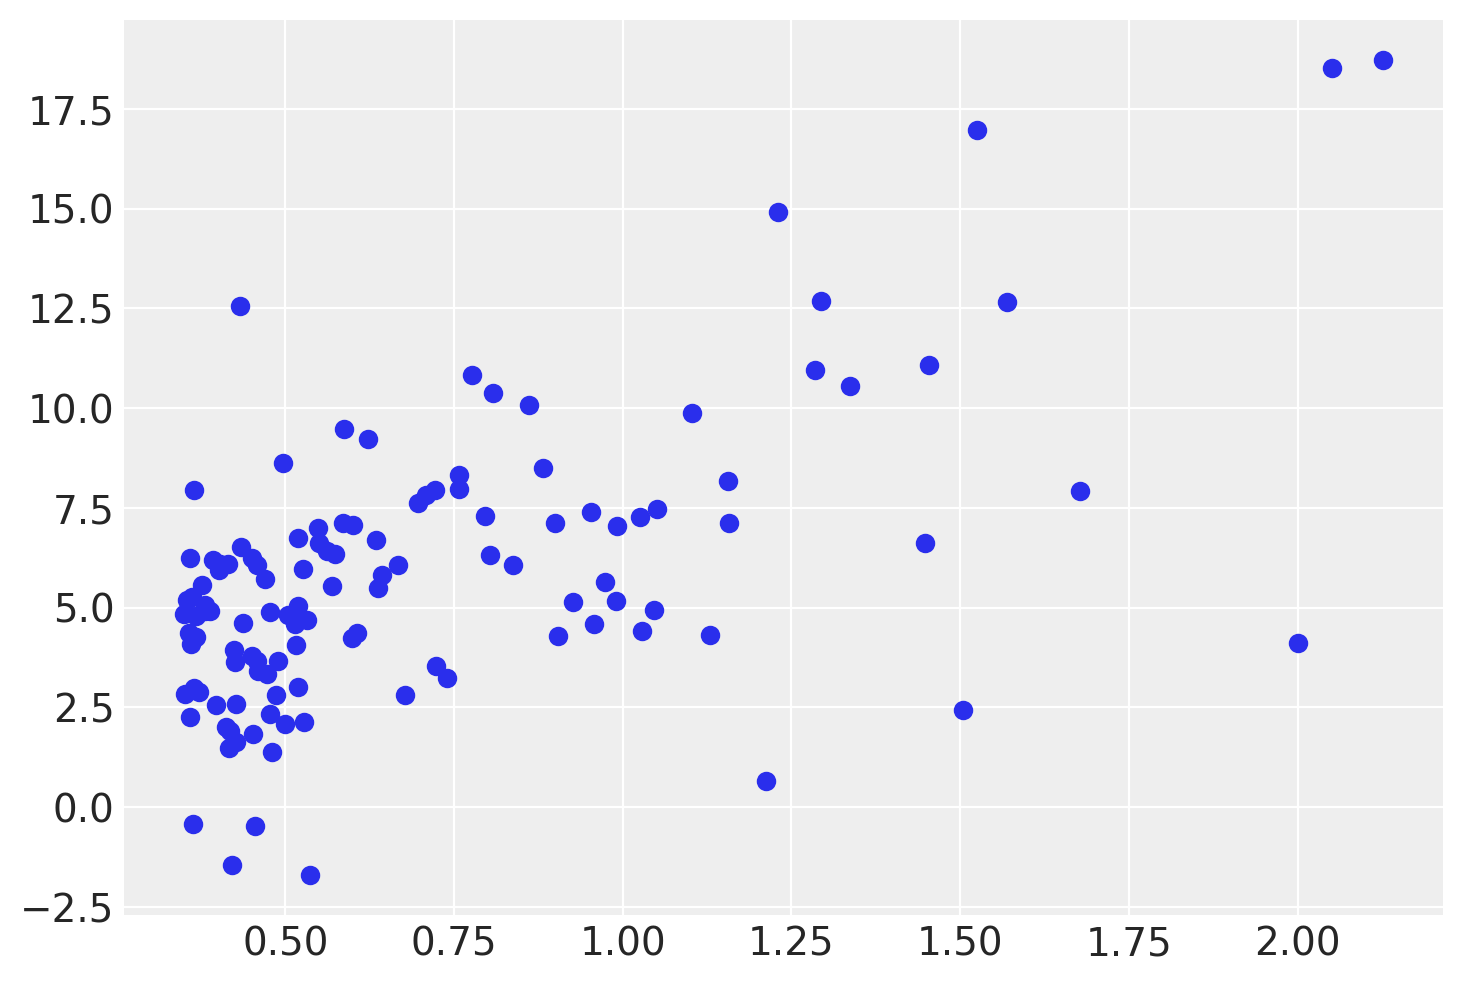

In [88]:

fig,ax=plt.subplots()
ax.scatter(df['M_exp'],df['profit'])

In [110]:
## standarize columns
d=df.assign(M_std=standarize(df['M_exp']),RD_std=standarize(df['RD_exp']),P_std=standarize(df['profit']))

In [111]:
M_shared=theano.shared(d['M_std'].values)
RD_shared=theano.shared(d['RD_std'].values)
with pm.Model() as m_1:
  a=pm.Normal('a',0,0.2)
  bM=pm.Normal('bM',0,0.5)
  bR=pm.Normal('bR',0,0.5)
  sigma=pm.Exponential('sigma',1)
  mu=pm.Deterministic('mu', a + bM*M_shared + bR*RD_shared)
  profit=pm.Normal('profit',mu=mu,sigma=sigma,observed=d['P_std'])
  trace4_1=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bR, bM, a]
Sampling chain 1, 0 divergences: 100%|██████████| 1000/1000 [00:00<00:00, 1225.18it/s]


In [114]:
az.summary(trace4_1,kind='stats',round_to=2,var_names=['~mu'])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5.5%,hdi_94.5%
a,0.00,0.07,-0.10,0.11
bM,0.55,0.07,0.45,0.66
bR,0.30,0.08,0.19,0.42
sigma,0.76,0.05,0.68,0.83


In [112]:

m4_ppc=pm.sample_posterior_predictive(trace4_1,1000,m_1)

100%|██████████| 1000/1000 [00:01<00:00, 699.68it/s]


Text(0, 0.5, 'Predicted')

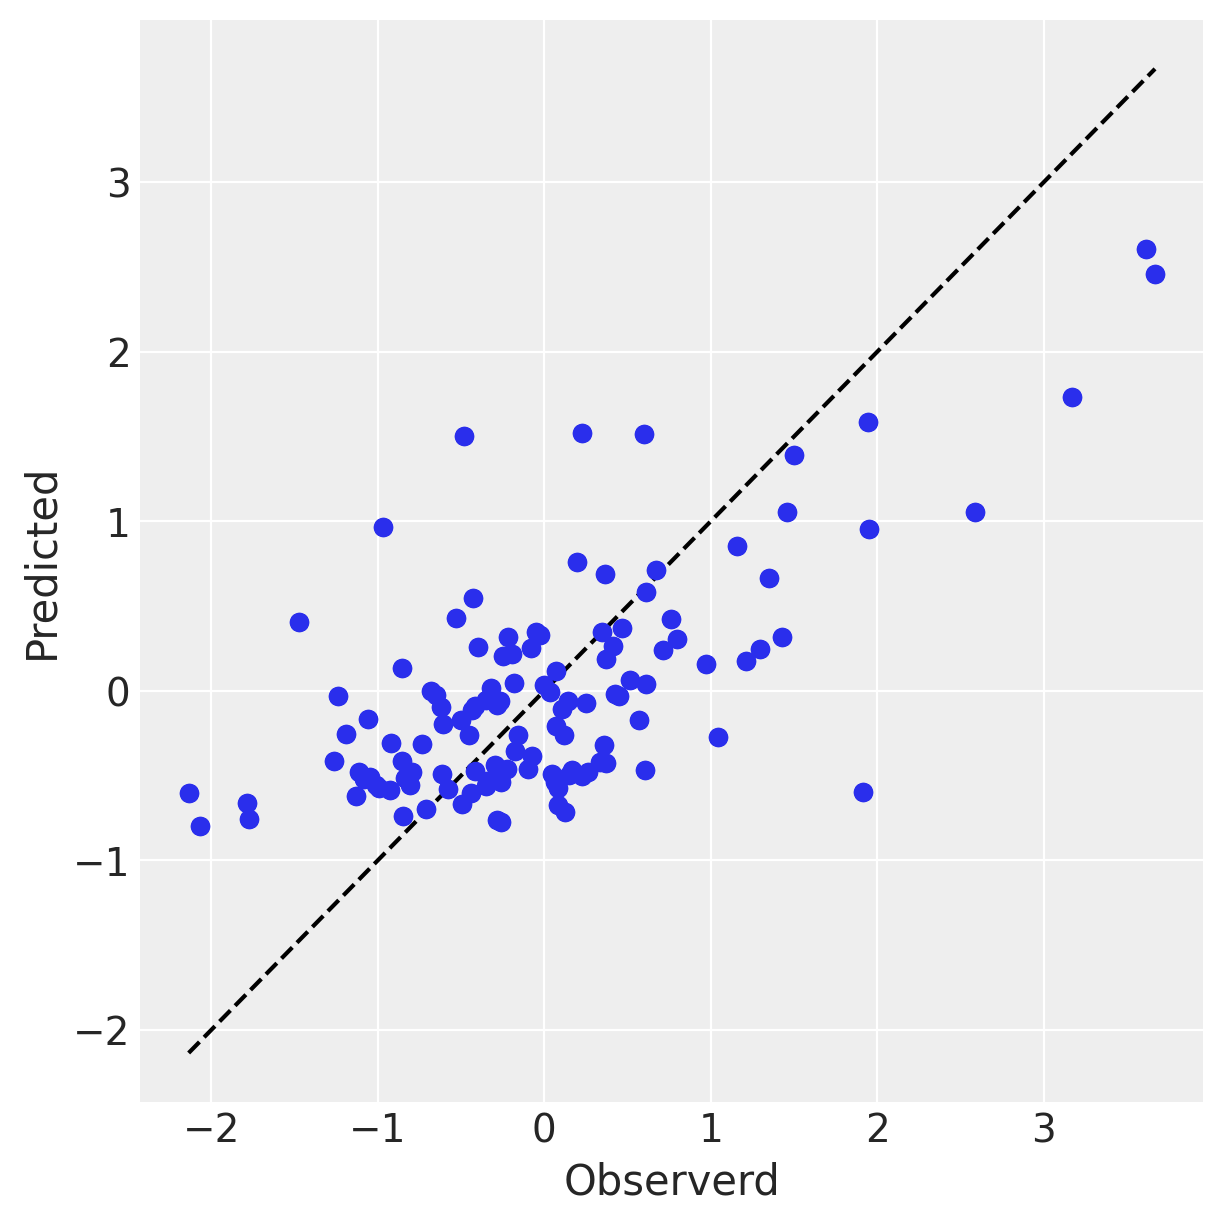

In [118]:
## posterior predictive plot
fig,ax=plt.subplots(figsize=(6,6))
ax.errorbar(d['P_std'],m4_ppc['profit'].mean(0),
            
            fmt="C0o")
ax.scatter(d['P_std'],m4_ppc['profit'].mean(0))
min,max=d['P_std'].min(),d['P_std'].max()
ax.plot([[min],[max]],[[min],[max]],'k--')
ax.set_xlabel('Observerd')
ax.set_ylabel('Predicted')